This notebook shows model and empirical scenarios.
# 1. Model experiment

## 1.1 Generating a reference trajectory

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import lfilter
from StatTools.analysis.dpcca import dpcca

In [2]:
config = {
    "overlap_step": 1,
    "hurst_min": 0.5,
    "hurst_max": 2.0,
    "rate": 12,
    "threads": 4,
}
s_array = np.array([2**i for i in range(3, config["rate"] - 2)])
h_list = [
    i * 0.01
    for i in range(
        int(config["hurst_min"] * 100), int(config["hurst_max"] * 100) + 1, 25
    )
]
trj_len = 2 ** config["rate"]

In [3]:
tab_colors = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
]

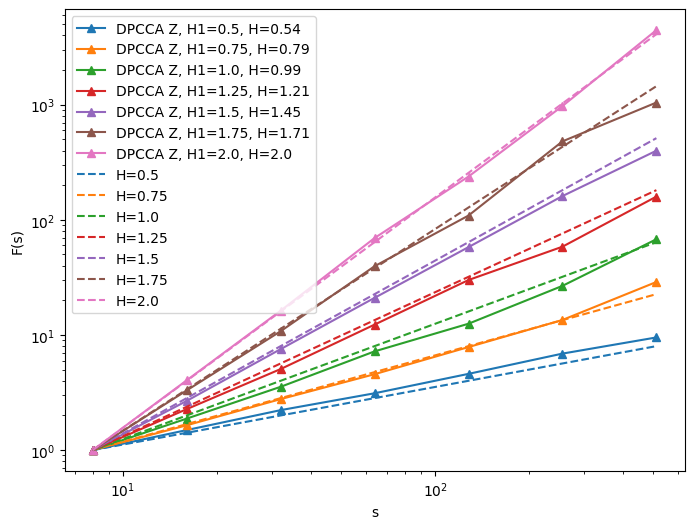

In [4]:
plt.figure(figsize=(8, 6))
for i, h in enumerate(h_list):
    X = np.random.randn(1, trj_len).flatten()
    B = (h - 0.5) * (np.arange(1, trj_len + 1)**(h - 1.5))
    beta = 2 * h - 1
    A = np.zeros_like(B)
    A[0] = 1.0
    for k in range(1, trj_len):
        A[k] = (k - 1 - beta / 2) * A[k - 1] / k
    Z = lfilter(np.ones(len(A)), A, X)
    sig_z = np.array(Z)

    p_z, r_z, f_z, s_z = dpcca(sig_z, 2, config["overlap_step"], s_array, processes=config["threads"], n_integral=0)
    f_z = np.sqrt(f_z) 
    f_z /= f_z[0]
    res = stats.linregress(np.log(s_z), np.log(f_z)).slope
    plt.loglog(s_array, f_z, '^-', label=f'DPCCA Z, H1={round(h, 2)}, H={round(res, 2)}', color=tab_colors[i])
for i, h in enumerate(h_list):
    plt.loglog(s_array, [s**h / s_array[0]**h for s in s_array], tab_colors[i], label=f'H={round(h, 2)}', linestyle='--')
plt.xlabel('s')
plt.ylabel('F(s)')
plt.legend()
plt.show()

In [5]:
signal_ds = np.ones((10, trj_len))

In [6]:
h = 0.8
B = (h - 0.5) * (np.arange(1, trj_len + 1)**(h - 1.5))
beta = 2 * h - 1
A = np.zeros_like(B)
A[0] = 1.0
for k in range(1, trj_len):
    A[k] = (k - 1 - beta / 2) * A[k - 1] / k
for i in range(10):
    x_array = np.random.randn(1, trj_len).flatten()
    signal = np.array(lfilter(np.ones(len(A)), A, x_array))
    signal_ds[i] = signal

## 1.2 Imitation of distortion

In [7]:
def add_noise(signal, snr_db):
    """
    Adds white Gaussian noise to a signal with a given SNR (in dB).
    
    Parameters:
        signal (np.array): The original signal.
        snr_db (float): The desired signal-to-noise ratio in decibels.
    
    Returns:
        np.array: A noisy signal.
    """
    signal_power = np.mean(signal ** 2)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    noisy_signal = signal + noise
    
    return noisy_signal

def add_gaps_fixed(signal, gap_duration, gap_frequency):
    """
    Adds gaps of fixed duration at certain intervals.
    
    Parameters:
        signal (np.array): The original signal.
        gap_duration (int): The duration of each pass in the reports.
        gap_frequency (int): The frequency of skips (every nth count).
    
    Returns:
        np.array: A signal with gaps (filled with NaN).
        np.array: Skip mask (1 - there is data, 0 - skip).
    """
    signal_with_gaps = signal.copy()
    mask = np.ones(len(signal), dtype=bool)
    
    for i in range(10, len(signal) - 10, gap_frequency):
        start = i
        end = min(i + gap_duration, len(signal))
        signal_with_gaps[start:end] = np.nan
        mask[start:end] = 0
    
    return signal_with_gaps, mask

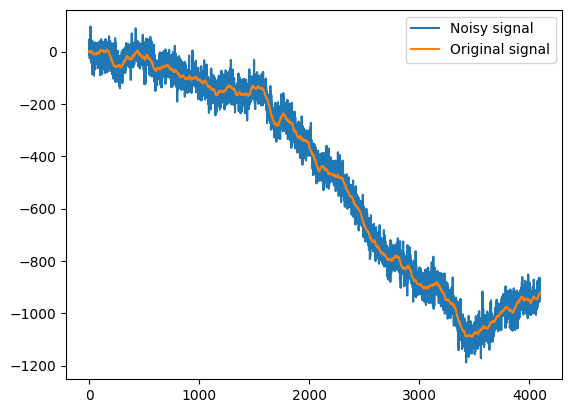

In [8]:
noisy_signal = add_noise(signal_ds[0], snr_db=25)
plt.plot(noisy_signal, label='Noisy signal')
plt.plot(signal_ds[0], label='Original signal')
plt.legend()
plt.show()

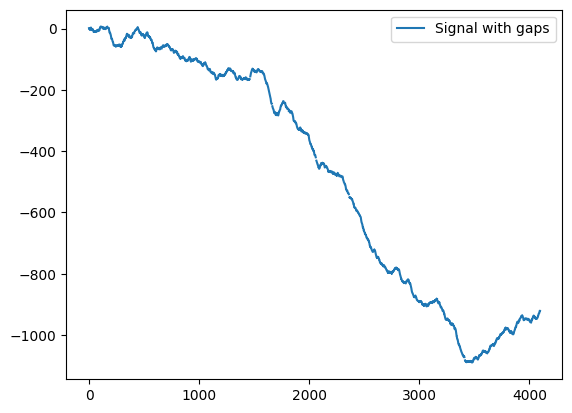

In [9]:
signal_with_gaps, gap_mask = add_gaps_fixed(signal_ds[0], gap_duration=5, gap_frequency=50)
plt.plot(signal_with_gaps, label='Signal with gaps')
plt.legend()
plt.show()

## 1.3 Reconstituting of trajectories

### lbfbm generator

In [24]:
from StatTools.generators.lbfbm_generator import LBFBmGenerator
from StatTools.analysis.dfa import DFA

In [53]:
dfa = DFA(np.diff(signal_ds[0]))
h = round(dfa.find_h(), 2)
base = 1.1
target_len = signal_ds[0].shape[0]
generator = LBFBmGenerator(h, base, length=target_len)
recovered_signal = np.zeros(target_len)

for i in range(target_len):
    if np.isnan(signal_with_gaps[i]):
        x = generator.__next__()
        recovered_signal[i] = x
        print(f"gap\ngen:{x:.2f}, orig:{signal_with_gaps[i]:.2f}")
    else:
        x = generator.next_with_value(signal_with_gaps[i])
        print(f"gen:{x:.2f}, orig:{signal_with_gaps[i]:.2f}")
        recovered_signal[i] = signal_with_gaps[i]

gen:1.11, orig:1.11
gen:1.35, orig:-0.12
gen:-0.28, orig:-1.82
gen:-2.13, orig:-1.42
gen:-2.17, orig:0.67
gen:-1.93, orig:0.51
gen:-2.87, orig:-0.87
gen:-5.81, orig:-2.57
gen:-9.17, orig:-2.25
gen:-14.24, orig:-3.57
gap
gen:-19.53, orig:nan
gap
gen:-21.36, orig:nan
gap
gen:-24.90, orig:nan
gap
gen:-28.16, orig:nan
gap
gen:-31.38, orig:nan
gen:-31.93, orig:1.50
gen:-30.59, orig:2.52
gen:-27.65, orig:3.27
gen:-24.70, orig:2.31
gen:-21.14, orig:2.50
gen:-18.83, orig:0.78
gen:-18.58, orig:-0.99
gen:-20.44, orig:-2.56
gen:-25.56, orig:-4.92
gen:-30.79, orig:-3.72
gen:-36.55, orig:-3.67
gen:-42.78, orig:-3.48
gen:-48.18, orig:-2.17
gen:-53.40, orig:-2.04
gen:-58.16, orig:-1.54
gen:-62.73, orig:-1.39
gen:-67.00, orig:-1.31
gen:-71.21, orig:-1.36
gen:-76.36, orig:-2.54
gen:-83.37, orig:-4.15
gen:-90.76, orig:-3.85
gen:-98.80, orig:-4.12
gen:-107.99, orig:-4.84
gen:-118.99, orig:-6.01
gen:-132.08, orig:-7.14
gen:-148.93, orig:-9.88
gen:-167.65, orig:-10.03
gen:-188.32, orig:-10.69
gen:-209.96, 

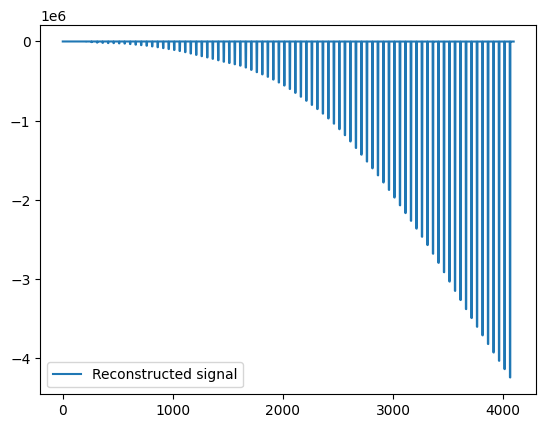

In [55]:
plt.plot(recovered_signal, label='Reconstructed signal')
# plt.plot(signal_with_gaps, label='Signal with gaps')
plt.legend()
plt.show()

## 1.4 Evaluation and analysis of results